In [1]:
%matplotlib inline
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules
%autoreload 2
# black formatter for jupyter notebooks
# %load_ext nb_black
# black formatter for jupyter lab
%load_ext lab_black

%run ../../src/notebook_env.py


---------------------------------
Working on the host: imarevic-pc

---------------------------------
Python version: 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:20:04) [GCC 11.3.0]

---------------------------------
Python interpreter: /home/imarevic/anaconda3/envs/srh/bin/python


# Bagging und Boosting bei Entscheidungsbäumen

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay,
)
from sklearn.preprocessing import StandardScaler

Im vorherigen Kapitel haben wir zur Reduktion der Varianz das Trimmen oder Pruning von Entscheidungsbäumen kennengelernt. Eine weitere Methode, die unabhängig vom verwendeten Model (Entscheidungsbaum, Regressionmodell, etc.) ist, ist das Bagging.

## Bagging

Das <a href="https://en.wikipedia.org/wiki/Bootstrap_aggregating">Bagging</a> ist eine Methode, die durch wiederholtes Sampling der Daten Vorhersagen verbessert. Die Fundamentale Idee stützt sich auf das simple Konzept der Berechnung eines Maßes der zentralen Tendenz (z. B. Mittelwert, Median, Modus), nur dass beim Bagging diese Maße auf Vorhersagen von Modellen angewendet werden:

Nehmen wir ein Set der Größe $n$ an **unabhängigen Beobachtungen** an (z.B. mehrere Datensätze der gleichen Art) und bezeichnen diese als $/_{1}, ..., Z_{n}$, wobei jeder Datnesatz die Varianz $\sigma$ besitzt und den mittelwert $\hat Z$. Dann ist die Varianz der Mittelwerte $\hat Z$ gegeben durch $\sigma²/n$. Anschaulich beduetet dies, dass die Bildung des Mittelwerts über mehrere Beobachtungen/Datensätze die Varianz **reduziert**.

Angewendet auf die Nutzung von Machine Learning Modellen, können somit mehrere Modell auf jeweils einer Stichprobe des Datensatzes trainiert werden und die resultierenden Vorhersagen gemittelt werden. 

Formal:

Wir berechnen $\hat f¹(x), \hat f²(x), ..., \hat f^B(x),$ unter Nutzung $B$ verschiedener Trainingsdatensätze. Dann lässt sich ein statistische Model mit geringer Varianz erzeugen durch

$$
\hat f_{gemittelt} = \frac{1}{B} \sum_{b=1}^B \hat f^b(x)
$$

Ind er Praxis stehen uns nicht mehrere unabhängige Trainingsdatensätze zur Verfügung und daher generieren wir aus dem Ursprungsdatensatz durch zufälliges wiederholtes ziehen von Stichproben mehrere **bootsrapped Trainingsdaten** (das ziehen mehrerer Stichproben mit Zurücklegen wird auch <a href="https://de.wikipedia.org/wiki/Bootstrapping-Verfahren">Bootstrap Sampling</a> genannt) um $\hat f^{*b}(x)$ zu berechnen und final durch Mitteln folgendes Model zu erhalten:

$$
\hat f_{bagged} = \frac{1}{B} \sum_{b=1}^B \hat f^{*b}(x)
$$

Dieses Verfahren, lässt sich auf jedes statistische Modell anwenden, jedoch findet es im Kontext der Entscheidungsbäume sehr häufig anwendung, da es hier zu besondres guten Modellen führt und die Flexibilität von Entscheidungsbäumen sehr gut ausnutzt. Zum Beispiel können nicht getrimmte Bäume verwendet werden, die sehr tief sind um dennoch mithilfe von Bagging sehr genaue Vorhersagen zu erhalten.

Im Falle einer nicht metrischen Vorhersagenvariablen (z.B. im Klassifikationskontext), kann Bagging ebenfalls wie folgt angewendet werden: Man fitted $B$ Klassifikationsbäume an die bootsrapped Trainingsdaten und merkt sich für jedes Model die am besten vorhergesagte Klasse. Aggregiert wird dann indem ein **Majority-Vote** vollzogen wird. Dies bedeutet, dass die finale Vorhersage, die am meisten vorkommende Vorhersage der $B$ Modelle ist.

Lassen Sie uns nun zur Veranschaulichung Bagging in Python demonstrieren.

### Bagging für Regressionsbäume in Python

Wir werden nun wieder die **Baseball Hitter-Daten** verwenden um Bagging im Regressionfall zu demonstrieren. Zunächst lesen wir den Datnsatz ein.

In [3]:
data = pd.read_csv("../../data/hitters.csv")
data = data.dropna()
data.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


Als nächstes wollen wir zum Vergleich einen Regressionsbaum fitten, der auf den gesamten Daten trainert wurde. Dieser soll als Baseline dienen, gegen die wir dann unser Baggin-Verfahren evaluieren können.

In [4]:
# Enkodierung der Daten
data = pd.get_dummies(data, drop_first=True)

#  Features und Target definieren
X_df = data.drop("Salary", axis=1)
y_df = data["Salary"]
X = X_df.values
y = y_df.values

# Standartisierung der Daten
scaler_X = StandardScaler()
X_standardized = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y_standardized = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

In [5]:
# Splitten der Daten in train, validatio und test set
X_train, X_temp, y_train, y_temp = train_test_split(
    X_standardized, y_standardized, test_size=0.4, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Fitten des Entscheidungsbaumes
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)
y_test_pred = tree.predict(X_test)

mse = mean_squared_error(y_test, y_test_pred)
print(f"Der MSE auf den Testdaten für einen globalen Regressionsbaum: {mse}")

Der MSE auf den Testdaten für einen globalen Regressionsbaum: 1.359673782288005


Lassen Sie uns nun Bagging mit $B=10000$ anwenden und den finalen Testfehler vergleichen. Wir werden immer 80% der Daten bootsrap samplen, also `samples_fraction = 0.8`.

In [6]:
B = 10000
samples_fraction = 0.8
models = []
test_preds = []
# Training loop
n_samples = int(len(X) * samples_fraction)
for b in range(1, B + 1):
    # ziehe Stichprobe mit Zurücklegen
    indices = np.random.choice(len(X_train), size=n_samples, replace=True)
    X_sample = X_train[indices]
    y_sample = y_train[indices]
    # fitte Entscheidungsbäume und speichere jedes Model
    tree = DecisionTreeRegressor(random_state=42)
    tree.fit(X_sample, y_sample)
    models.append(tree)


# prediction loop
predictions = np.zeros((X_test.shape[0], B))
# Erzeuge Vorhersage auf Testdaten und speichere in Liste
for i, model in enumerate(models):
    predictions[:, i] = model.predict(X_test)

# Berechne Mittelwert über alle Vorhersagen
bagged_preds = np.mean(predictions, axis=1)

# Berechne MSE
mse = mean_squared_error(y_test, bagged_preds)
print(f"Der MSE auf den Testdaten für einen bagged Regressionsbaum: {mse}")

Der MSE auf den Testdaten für einen bagged Regressionsbaum: 0.7814575209501579


Wir sehen also, dass der Testfehler geringer ausfällt und wir somit ein besseres Model zur Vorhersage durch Bagging erhalten haben.

### Bagging für Klassifikationsbäume in Python

Im Folgenden werden wir der Vollständigkeit halber Bagging auch auf Klassifikationsbäume anwenden. Die Implementierung ist im Prinzip identisch zum Regressionsfall. Wir werden analog zum vorherigen Kapitel nun ebenfalls den **Hurricane-Datensatz** verwenden:

In [7]:
hurricanes = pd.read_excel("../../data/hurricanes.xlsx", index_col=0)
hurricanes.head(5)

,Number,Name,Year,Type,FirstLat,FirstLon,MaxLat,MaxLon,LastLat,LastLon,MaxInt
RowNames,,,,,,,,,,,
1,430,NOTNAMED,1944,1,30.2,-76.1,32.1,-74.8,35.1,-69.2,80
2,432,NOTNAMED,1944,0,25.6,-74.9,31.0,-78.1,32.6,-78.2,80
3,433,NOTNAMED,1944,0,14.2,-65.2,16.6,-72.2,20.6,-88.5,105
4,436,NOTNAMED,1944,0,20.8,-58.0,26.3,-72.3,42.1,-71.5,120
5,437,NOTNAMED,1944,0,20.0,-84.2,20.6,-84.9,19.1,-93.9,70


In [8]:
# Benamung der Origin
hurricanes["Origins"] = hurricanes["Type"].replace(
    {0: "tropisch", 1: "aussertropisch", 3: "aussertropisch"}
)
# Erstellung von X und y Datensätzen
X = hurricanes["FirstLat"].values
X = sm.add_constant(X)
y = hurricanes["Origins"].replace({"tropisch": 0, "aussertropisch": 1}).values

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Nun haben wir Test und Trainingsdaten und können mit der Implementierung der Bagging Variante des Klassifikaitonsbaumes fortfahren. Die Implementierung sieht wie folgt aus:

In [9]:
B = 10000
samples_fraction = 0.8
models = []
test_preds = []
# Training loop
n_samples = int(len(X) * samples_fraction)
for b in range(1, B + 1):
    # ziehe Stichprobe mit Zurücklegen
    indices = np.random.choice(len(X_train), size=n_samples, replace=True)
    X_sample = X_train[indices]
    y_sample = y_train[indices]
    # fitte Entscheidungsbäume und speichere jedes Model
    tree = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)
    tree.fit(X_sample, y_sample)
    models.append(tree)


# prediction loop
predictions = np.zeros((X_test.shape[0], B), dtype=int)
# Erzeuge Vorhersage auf Testdaten und speichere in Liste
for i, model in enumerate(models):
    predictions[:, i] = model.predict(X_test)

# Berechne Majority Vote über alle Vorhersagen
bagged_preds = np.array(
    [np.bincount(predictions[i]).argmax() for i in range(predictions.shape[0])]
)

Wir berechnen auch hier die Accuracy:

In [10]:
# Berechne Accuracy
acc = accuracy_score(y_test, bagged_preds)
print(
    f"Der Accuracy Score auf den Testdaten für einen bagged Klassifikationsbaum: {acc}"
)

Der Accuracy Score auf den Testdaten für einen bagged Klassifikationsbaum: 0.8235294117647058


## Boosting

Genauso wie das Bagging, kann <a href="https://de.wikipedia.org/wiki/Boosting">Boosting</a> generell bei allen machine leanring Verfahren eingesetzt werden. Es ist vom Prizip her nicht auf Entscheidungsbäume beschränkt, da es aber bei einer Variante der Random Forests zum Einsatz kommt und somit im Kontext der Entscheidungsbäume sehr verbreitet ist, werden wir Boosting ebenfalls unter Verwendung von Entscheidungsbäumen vorstellen. 

Wir erinnern uns, dass beim Bagging das *Bootstrap Sampling* zum Einsatz kam um für jedes Model eine neue Stichprobe zu ziehen und die Vorhersagen am Ende global zu aggregieren. Im Gegensatz hierzu involviert das Boosting nicht wiederholtes Ziehen eines Bootsrap Samples, sondern es ist ein **sequentielles Verfahren**, dass Informationen von zuvor aufgespannten Entscheidungsbäume in das Lernverfahren einbezieht und somit jeder Entscheidungsbaum auf einer modifizierten Version der Originaldaten trainiert wird.

Im Gegensatz zum Bagging ist das Boosting ein **langsames Verfahren**. Es wird so bezeichnet, da hier ein Entscheidungsbaum zunächst auf die Daten gefittet wird und danach immer wieder auf die Residuen der vorhersagen des vorherigen Models. Es werden also zu jeder Iteration die **Residuen** als $Y$ betrachte und ein Model darauf trainiert. Der resultierende Baum wird dann nach jeder Iteration zurück in die gefittete Funktion integriert um die Residuen zu updaten. Die verwendeten Bäume können hierbei sehr klein sein. Beim Boosting wird diese Tiefe durch den Parameter $d$ kontrolliert. Durch Nutzung sehr kleiner Bäume, verbessern wir die Vorhersage sehr *langsam* und Verbessern somit die finale Funktion $\hat f$, die das Gesamtmodel über die Iterationen beschreibt besonders in den Bereichen, in denen das Model schlechte Vorhersagen macht. Das sehr langsame Lernen wird noch weiter verlangsamit, wenn wir einen Parameter $\lambda$ einbauen, der die Lernrate verringert und somit erlaubt verschiedene Bäume aufzubauen, da insgesamt mehr Bäume möglich sind.

Formal lässt sich der Boosting-Algorithmus wie folgt beschreiben:

1. Setze $\hat f(x)=0$ und $r_{i} = y_{i}$ für alle Beobachtungen $i$ im Trainingsdatensatz.
2. Für $b =1,2, ..., B$, wiederhole folgendes:
    
    A. Fitte einen Baum $\hat f^b$ mit $d$ Splits (d+1 finale Knoten) an die Trainingsdaten.
    
    B. Update $\hat f$ durch hinzufügen einer kleineren Version des vorherigen Baumes:
    
$$
\hat f(x) \leftarrow \hat f(x) + \lambda \hat f^b(x)
$$
    
    C. Update die Residuen r:
    
$$
r_{i} \leftarrow r_{i} - \lambda \hat f^b(x_{i})
$$


3. Gebe das geboostete Model zurück:

$$
\hat f(x) = \sum_{b=1}^B \lambda \hat f^b(x)
$$

Im generellen Boosting-Algorithmus sind folgende Parameter involviert:
    

|  Parameter | Beschreibung  |
|---|---|
|  B | Die Anzahl an Bäumen. Wenn B zu groß gewählt wird, kann eine Boosting-Agorithmus overfitten. Daher wird B häufig durch Krossvalidierung auf einem Validierungsdatensatz gewählt  |
|  $\lambda$  | Dieser Parameter wird **Shrinkage Patameter** genannt, da dieser die Lernrate kontrolliert, mit der der Boosting-Algorithmus lernt. Er sorgt dafür dass die Bäume sich über mehrere Iterationen nicht zu sehr ähneln.|
| $d$ | Dieser Parameter kontrolliert die Komplexität der Bäume. Beim Boosting werden häufig nur sehr geringe Tiefen gewählt. Meistens reicht eine Tiefe von $d=1$ vollkommen aus (nur 1 Split).|

### Boosting in Python

In Python lässt sich Boosting bei Entscheidungsbäumen gut mit der Bibliothek `scikit-learn`implementieren. Hierbei ist zu beachten, dass verschieden Varianten des oben beschriebenen Boosting-Algorithmus existieren:

- AdaBoost (Adaptive Boosting)
- Gradient Boost
- XGBoost

Jede dieser Varianten. Zum Beispiel werden bei AdaBoost die Gewichte des Models bei jeder Iteration geupdatet und bei Gradient Boosting wird oben bschriebens Udate Verfahren über die Residuen gewählt. XGBoost ermöglicht noch weitere Regularizierung des Models. Die Details jedes dieser Verfahren sind jedoch nicht Gegenstand dieses Moduls.

Im Folgenden werden wir anschaulich Gradient Boosting aus `scikit-learn` in Python verwenden. Wir nutzen hierfür wieder den Baseball Hitter Datensatz:

In [11]:
data = pd.read_csv("../../data/hitters.csv")
data = data.dropna()
data.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [12]:
# Enkodierung der Daten
data = pd.get_dummies(data, drop_first=True)

#  Features und Target definieren
X_df = data.drop("Salary", axis=1)
y_df = data["Salary"]
X = X_df.values
y = y_df.values

# Standartisierung der Daten
scaler_X = StandardScaler()
X_standardized = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y_standardized = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Splitten der Daten in train, validatio und test set
X_train, X_temp, y_train, y_temp = train_test_split(
    X_standardized, y_standardized, test_size=0.4, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

Nun werden wir den `GradientBoostingRegressor()` auf die Trainisdaten anwenden und den MSE auf dem Testdatensatz ausgeben. Es ist zu bacten, dass wir im Dictionary `params` ein paar **Hyperparameter** setzen, die das Training kontrollieren. In unserem Beispiel wählen wir die verbreiteten Settings (z.B. `n_estimators : 500` oder `learning_rate : 0.01`) und erlauben nur sehr keine Bäume (`mas_depth : 4`):

In [13]:
# Setzen der Lernparameter
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

# Modelfitting
reg = GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

# MSE
mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) auf den Testdaten: {:.4f}".format(mse))

The mean squared error (MSE) auf den Testdaten: 0.8217


Um zu veranschaulichen wie der Boosting-Algorithmus **langsam** auf den Traininsdaten lernt und bei jeder Iteration die **vorherige Vorhersage etwas verbessert**, werden wir nun den Trainings- und Testfehler für jede Iteration $B = 1, 2, ..., N$ plotten.

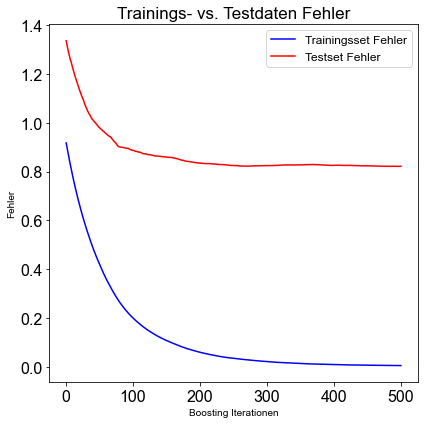

In [14]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Trainings- vs. Testdaten Fehler")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Trainingsset Fehler",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Testset Fehler"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterationen")
plt.ylabel("Fehler")
fig.tight_layout()
plt.show()

Zum Abschluss lässt sich Bagging und Boosting wie folgt zusammenfassen:

![bagging_vs_boosting](../_img/bagging_vs_boosting.png "Bagging vs. Boosting")

> **Bagging**:<br>
> - Ziehe N Trainingsdatensätze mit Zurücklegen
> - Trainiere auf jedem der Datensätze ein Modell
> - Aggregiere die Vorhersagen der Modelle um eine genauere finale Vorhersage zu erhalten

> **Boosting**:<br>
> - Trainiere ein Modell auf den Trainingsdaten
> - Fitte das Model auf die Residuen des vorherigen Trainingslaufs und update die Residuen
> - Füge bei jeder Iteration sequentiell das erhaltene Model dem Ursprungsmodel hinzu